In [15]:
import warnings
warnings.filterwarnings('ignore')
try:
  import requests
  import pymysql
  import sqlalchemy
  from google.cloud.sql.connector import connector
  from getpass import getpass
except:
  ! python -m pip install pymysql
  ! python -m pip install cloud-sql-python-connector[pg8000]
  ! python -m pip install urllib3
  ! python -m pip install getpass

import os
import pandas as pd
import json
import urllib.request
import requests
import pymysql
import sqlalchemy
from google.cloud.sql.connector import connector
import time
import numpy as np
import collections
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import altair as alt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import cdist
import psycopg2.extras
from scipy import stats

### Postgres DB Connector

In [2]:
# load .json credentials for Google service --- upload .json from downloads local folder to colab instance
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "opensea-333804-f005233a666e.json"

# create connection to database
def getconn() -> pymysql.connections.Connection:
  conn: pymysql.connections.Connection = connector.connect("opensea-333804:us-west1:opensea","pg8000",user="postgres",password="Thor2020!",db="postgres")
  return conn

pool = sqlalchemy.create_engine("postgresql+pg8000://",creator=getconn)

### Event Data Load (Postgres DB)
** only used for generating a list of wallet_addresses to build and test recommender system ** 

In [ ]:
# # load data from postgres tables into dataframe
# df = pd.DataFrame()
# for table_name in ['os_data_event_rb','os_data_event']:
#   data_SQL = "SELECT approved_account,asset_bundle,auction_type,bid_amount,collection_slug,contract_address,created_date,custom_event_name,dev_fee_payment_event,dev_seller_fee_basis_points,duration,ending_price,event_type,id,is_private,owner_account,quantity,seller,starting_price,to_account,total_price,transaction,winner_account,listing_time,asset_id,asset_num_sales,asset_background_color,asset_image_url,asset_image_preview_url,asset_image_thumbnail_url,asset_image_original_url,asset_animation_url,asset_animation_original_url,asset_name,asset_description,asset_external_link,asset_asset_contract_address,asset_asset_contract_asset_contract_type,asset_asset_contract_created_date,asset_asset_contract_name,asset_asset_contract_nft_version,asset_asset_contract_opensea_version,asset_asset_contract_owner,asset_asset_contract_schema_name,asset_asset_contract_symbol,asset_asset_contract_total_supply,asset_asset_contract_description,asset_asset_contract_external_link,asset_asset_contract_image_url,asset_asset_contract_default_to_fiat,asset_asset_contract_dev_buyer_fee_basis_points,asset_asset_contract_dev_seller_fee_basis_points,asset_asset_contract_only_proxied_transfers,asset_asset_contract_opensea_buyer_fee_basis_points,asset_asset_contract_opensea_seller_fee_basis_points,asset_asset_contract_buyer_fee_basis_points,asset_asset_contract_seller_fee_basis_points,asset_asset_contract_payout_address,asset_permalink,asset_collection_banner_image_url,asset_collection_chat_url,asset_collection_created_date,asset_collection_default_to_fiat,asset_collection_description,asset_collection_dev_buyer_fee_basis_points,asset_collection_dev_seller_fee_basis_points,asset_collection_discord_url,asset_collection_display_data_card_display_style,asset_collection_external_url,asset_collection_featured,asset_collection_featured_image_url,asset_collection_hidden,asset_collection_safelist_request_status,asset_collection_image_url,asset_collection_is_subject_to_whitelist,asset_collection_large_image_url,asset_collection_medium_username,asset_collection_name,asset_collection_only_proxied_transfers,asset_collection_opensea_buyer_fee_basis_points,asset_collection_opensea_seller_fee_basis_points,asset_collection_payout_address,asset_collection_require_email,asset_collection_short_description,asset_collection_slug,asset_collection_telegram_url,asset_collection_twitter_username,asset_collection_instagram_username,asset_collection_wiki_url,asset_decimals,asset_token_metadata,asset_owner_user_username,asset_owner_profile_img_url,asset_owner_address,asset_owner_config,asset_token_id,from_account_user_username,from_account_profile_img_url,from_account_address,from_account_config,payment_token_id,payment_token_symbol,payment_token_address,payment_token_image_url,payment_token_name,payment_token_decimals,payment_token_eth_price,payment_token_usd_price FROM {}".format(table_name)
#   data = []
#   with pool.connect() as db_conn:
#     # get  data from table
#     data_payload = db_conn.execute('{}'.format(data_SQL)).fetchall()
#     for row in data_payload:
#       data.append(row)

#   col_names = ['approved_account','asset_bundle','auction_type','bid_amount','collection_slug','contract_address','created_date','custom_event_name','dev_fee_payment_event','dev_seller_fee_basis_points','duration','ending_price','event_type','id','is_private','owner_account','quantity','seller','starting_price','to_account','total_price','transaction','winner_account','listing_time','asset_id','asset_num_sales','asset_background_color','asset_image_url','asset_image_preview_url','asset_image_thumbnail_url','asset_image_original_url','asset_animation_url','asset_animation_original_url','asset_name','asset_description','asset_external_link','asset_asset_contract_address','asset_asset_contract_asset_contract_type','asset_asset_contract_created_date','asset_asset_contract_name','asset_asset_contract_nft_version','asset_asset_contract_opensea_version','asset_asset_contract_owner','asset_asset_contract_schema_name','asset_asset_contract_symbol','asset_asset_contract_total_supply','asset_asset_contract_description','asset_asset_contract_external_link','asset_asset_contract_image_url','asset_asset_contract_default_to_fiat','asset_asset_contract_dev_buyer_fee_basis_points','asset_asset_contract_dev_seller_fee_basis_points','asset_asset_contract_only_proxied_transfers','asset_asset_contract_opensea_buyer_fee_basis_points','asset_asset_contract_opensea_seller_fee_basis_points','asset_asset_contract_buyer_fee_basis_points','asset_asset_contract_seller_fee_basis_points','asset_asset_contract_payout_address','asset_permalink','asset_collection_banner_image_url','asset_collection_chat_url','asset_collection_created_date','asset_collection_default_to_fiat','asset_collection_description','asset_collection_dev_buyer_fee_basis_points','asset_collection_dev_seller_fee_basis_points','asset_collection_discord_url','asset_collection_display_data_card_display_style','asset_collection_external_url','asset_collection_featured','asset_collection_featured_image_url','asset_collection_hidden','asset_collection_safelist_request_status','asset_collection_image_url','asset_collection_is_subject_to_whitelist','asset_collection_large_image_url','asset_collection_medium_username','asset_collection_name','asset_collection_only_proxied_transfers','asset_collection_opensea_buyer_fee_basis_points','asset_collection_opensea_seller_fee_basis_points','asset_collection_payout_address','asset_collection_require_email','asset_collection_short_description','asset_collection_slug','asset_collection_telegram_url','asset_collection_twitter_username','asset_collection_instagram_username','asset_collection_wiki_url','asset_decimals','asset_token_metadata','asset_owner_user_username','asset_owner_profile_img_url','asset_owner_address','asset_owner_config','asset_token_id','from_account_user_username','from_account_profile_img_url','from_account_address','from_account_config','payment_token_id','payment_token_symbol','payment_token_address','payment_token_image_url','payment_token_name','payment_token_decimals','payment_token_eth_price','payment_token_usd_price']
#   df_rb = pd.DataFrame(data=data, columns = col_names)
#   df = pd.concat([df,df_rb])
#   time.sleep(30)
# df.shape

In [ ]:
# save data as json file to avoid loading in from PG database each time
# df_json = df.to_json(orient="split")
# with open('json_data_2022_03_04.json', 'w') as outfile:
#     json.dump(df_json, outfile)

# load data from json file to avoid loading from PG database each time
# df = pd.read_json('json_data_2022_03_04.json')

### NFT Wallet Data Load (Postgres DB)
** used to build and test NFT recommender system in DEV **

In [4]:
# load wallet data from PG database
table_name = 'os_wallet_data'
data_SQL = "SELECT * FROM {} WHERE event_type in ('successful','created')".format(table_name)
data = []
with pool.connect() as db_conn:
  # get  data from table
  data_payload = db_conn.execute('{}'.format(data_SQL)).fetchall()
  for row in data_payload:
    data.append(row)
col_names = ['asset_id', 'asset_num_sales', 'asset_image_url', 'asset_image_preview_url', 'asset_image_thumbnail_url', 'asset_image_original_url', 'asset_name', 'asset_description', 'asset_asset_contract_address', 'asset_asset_contract_asset_contract_type', 'asset_asset_contract_created_date', 'asset_asset_contract_name', 'asset_asset_contract_nft_version', 'asset_asset_contract_owner', 'asset_asset_contract_schema_name', 'asset_asset_contract_symbol', 'asset_asset_contract_total_supply', 'asset_asset_contract_description', 'asset_asset_contract_external_link', 'asset_asset_contract_image_url', 'asset_asset_contract_default_to_fiat', 'asset_asset_contract_dev_buyer_fee_basis_points', 'asset_asset_contract_dev_seller_fee_basis_points', 'asset_asset_contract_only_proxied_transfers', 'asset_asset_contract_opensea_buyer_fee_basis_points', 'asset_asset_contract_opensea_seller_fee_basis_points', 'asset_asset_contract_buyer_fee_basis_points', 'asset_asset_contract_seller_fee_basis_points', 'asset_asset_contract_payout_address', 'asset_permalink', 'asset_collection_banner_image_url', 'asset_collection_created_date', 'asset_collection_default_to_fiat', 'asset_collection_description', 'asset_collection_dev_buyer_fee_basis_points', 'asset_collection_dev_seller_fee_basis_points', 'asset_collection_discord_url', 'asset_collection_display_data_card_display_style', 'asset_collection_external_url', 'asset_collection_featured', 'asset_collection_featured_image_url', 'asset_collection_hidden', 'asset_collection_safelist_request_status', 'asset_collection_image_url', 'asset_collection_is_subject_to_whitelist', 'asset_collection_large_image_url', 'asset_collection_name', 'asset_collection_only_proxied_transfers', 'asset_collection_opensea_buyer_fee_basis_points', 'asset_collection_opensea_seller_fee_basis_points', 'asset_collection_payout_address', 'asset_collection_require_email', 'asset_collection_slug', 'asset_collection_twitter_username', 'asset_collection_instagram_username', 'asset_collection_is_nsfw', 'asset_decimals', 'asset_token_metadata', 'asset_is_nsfw', 'asset_owner_user_username', 'asset_owner_profile_img_url', 'asset_owner_address', 'asset_token_id', 'collection_slug', 'contract_address', 'created_date', 'event_type', 'from_account_user_username', 'from_account_profile_img_url', 'from_account_address', 'id', 'is_private', 'quantity', 'to_account_user_username', 'to_account_profile_img_url', 'to_account_address', 'transaction_block_hash', 'transaction_block_number', 'transaction_from_account_user_username', 'transaction_from_account_profile_img_url', 'transaction_from_account_address', 'transaction_id', 'transaction_timestamp', 'transaction_to_account_profile_img_url', 'transaction_to_account_address', 'transaction_transaction_hash', 'transaction_transaction_index', 'listing_time', 'payment_token_id', 'payment_token_symbol', 'payment_token_address', 'payment_token_image_url', 'payment_token_name', 'payment_token_decimals', 'payment_token_eth_price', 'payment_token_usd_price', 'seller_user_username', 'seller_profile_img_url', 'seller_address', 'wallet_address', 'timestmp']
w_df = pd.DataFrame(data=data, columns = col_names)
# rebuild asset_num_sales from prior str cleaning resulting in decimal replacement with whitespace
w_df['asset_num_sales'].fillna('0', inplace = True)
w_df['asset_num_sales'] = w_df['asset_num_sales'].str.replace('nan','0').apply(lambda x: int(str(x).split(' ')[0]))
# rebuild payment_token_usd_price from prior str cleaning resulting in decimal replacement with whitespace
w_df['payment_token_usd_price'].fillna('0', inplace = True)
w_df['payment_token_usd_price'] = w_df['payment_token_usd_price'].str.replace('None','0').str.replace('nan','0').apply(lambda x: int(str(x).split(' ')[0]))

w_df['token_id_contract_address'] = w_df['asset_token_id'] + w_df['asset_asset_contract_address'] 
print('unique NFTs + contracts in the dataset: {}'.format(w_df['token_id_contract_address'].nunique()))
print('unique wallets in the dataset: {}'.format(w_df['wallet_address'].nunique()))
print('total records in dataset: {}'.format(len(w_df)))

unique NFTs + contracts in the dataset: 174805
unique wallets in the dataset: 2654
total records in dataset: 472453


In [5]:
# randomly sample an NFT wallet
pd.set_option('display.max_columns',250)
w_df[w_df.wallet_address == w_df.wallet_address.sample().values[0]].head(1)

,asset_id,asset_num_sales,asset_image_url,asset_image_preview_url,asset_image_thumbnail_url,asset_image_original_url,asset_name,asset_description,asset_asset_contract_address,asset_asset_contract_asset_contract_type,asset_asset_contract_created_date,asset_asset_contract_name,asset_asset_contract_nft_version,asset_asset_contract_owner,asset_asset_contract_schema_name,asset_asset_contract_symbol,asset_asset_contract_total_supply,asset_asset_contract_description,asset_asset_contract_external_link,asset_asset_contract_image_url,asset_asset_contract_default_to_fiat,asset_asset_contract_dev_buyer_fee_basis_points,asset_asset_contract_dev_seller_fee_basis_points,asset_asset_contract_only_proxied_transfers,asset_asset_contract_opensea_buyer_fee_basis_points,asset_asset_contract_opensea_seller_fee_basis_points,asset_asset_contract_buyer_fee_basis_points,asset_asset_contract_seller_fee_basis_points,asset_asset_contract_payout_address,asset_permalink,asset_collection_banner_image_url,asset_collection_created_date,asset_collection_default_to_fiat,asset_collection_description,asset_collection_dev_buyer_fee_basis_points,asset_collection_dev_seller_fee_basis_points,asset_collection_discord_url,asset_collection_display_data_card_display_style,asset_collection_external_url,asset_collection_featured,asset_collection_featured_image_url,asset_collection_hidden,asset_collection_safelist_request_status,asset_collection_image_url,asset_collection_is_subject_to_whitelist,asset_collection_large_image_url,asset_collection_name,asset_collection_only_proxied_transfers,asset_collection_opensea_buyer_fee_basis_points,asset_collection_opensea_seller_fee_basis_points,asset_collection_payout_address,asset_collection_require_email,asset_collection_slug,asset_collection_twitter_username,asset_collection_instagram_username,asset_collection_is_nsfw,asset_decimals,asset_token_metadata,asset_is_nsfw,asset_owner_user_username,asset_owner_profile_img_url,asset_owner_address,asset_token_id,collection_slug,contract_address,created_date,event_type,from_account_user_username,from_account_profile_img_url,from_account_address,id,is_private,quantity,to_account_user_username,to_account_profile_img_url,to_account_address,transaction_block_hash,transaction_block_number,transaction_from_account_user_username,transaction_from_account_profile_img_url,transaction_from_account_address,transaction_id,transaction_timestamp,transaction_to_account_profile_img_url,transaction_to_account_address,transaction_transaction_hash,transaction_transaction_index,listing_time,payment_token_id,payment_token_symbol,payment_token_address,payment_token_image_url,payment_token_name,payment_token_decimals,payment_token_eth_price,payment_token_usd_price,seller_user_username,seller_profile_img_url,seller_address,wallet_address,timestmp,token_id_contract_address
354951,323760115 0,2,https storage opensea io files c1c2ab9e8a1f54d...,https storage opensea io files c1c2ab9e8a1f54d...,https storage opensea io files c1c2ab9e8a1f54d...,https cyberbrokers api images s3 amazonaws com...,Ri qira Echo,Every story has its villain Sometimes they re ...,0x892848074ddea461a15f337250da3ce55580ca85,non fungible,2022 03 04T01 32 57 234104,CyberBrokers,3 0,267174427 0,ERC721,CYBERBROKERS,1,The artist Josie Bellini presents CyberBrokers...,https cyberbrokers io,https lh3 googleusercontent com Qd1IEPYz 0YlMa...,False,0 0,500 0,False,0 0,250 0,0 0,750 0,0x070cbef6414f8f0070a98051658bef840bcd86de,https opensea io assets 0x892848074ddea461a15f...,https lh3 googleusercontent com dEXZvqGDm z6CY...,2022 03 04T01 32 58 506052,False,The artist Josie Bellini presents CyberBrokers...,0,500,https discord gg josie,contain,https cyberbrokers io,False,https lh3 googleusercontent com duFsfRauDX27H7...,False,approved,https lh3 googleusercontent com Qd1IEPYz 0YlMa...,False,https lh3 googleusercontent com duFsfRauDX27H7...,CyberBrokers,False,0,250,0x070cbef6414f8f0070a98051658bef840bcd86de,False,cyberbrokers,None,None,False,0 0,https cyberbrok

### NFT Wallet Data Processing & Feature Engineering
** used to build model for classifying wallet type and generating intuition on right number of wallet owner types **

Wallet feature engineering: we hypothesize some combination of these features might enable wallet profiling / clustering to drive a more precise recommender logic based on wallet characterization
- Total unique NFTS held
- Total NFTs purchased, and % of total held
- Total NFTs minted, and % of total held
- Total NFTs sold, and % of total held 
- Count of unique collections held
- Count of the max collection holding
- Count of min collection holding
- Count of mean collection holdering
- Average of NFT volume for NFTs in the wallet
- Median of NFT volume for NFTs in the wallet
- Min of NFT volume for NFTs in the wallet
- Max of NFT volume for NFTs in the wallet

In [7]:
# feature creation / wallet data aggregation (per the above)
total_nft_held = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_token_id'].nunique()
total_nft_transacted = w_df[w_df.event_type == 'successful'].groupby('wallet_address')['asset_token_id'].nunique()
total_nft_sale = w_df[(w_df.seller_address == w_df.wallet_address)].groupby('wallet_address')['asset_token_id'].nunique()
unique_collections_held = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['collection_slug'].nunique()
max_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.max}).reset_index().set_index('wallet_address')
min_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.min}).reset_index().set_index('wallet_address')
avg_collection_count = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address','collection_slug']).agg({'asset_id':lambda x: len(np.unique(x))}).groupby('wallet_address').agg({'asset_id':np.mean}).reset_index().set_index('wallet_address')
avg_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].mean()
median_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].median()
min_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].min()
max_nft_vol = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby('wallet_address')['asset_num_sales'].max()
avg_eth_usd_price = w_df[(w_df.asset_owner_address == w_df.wallet_address)].groupby(['wallet_address']).agg({'payment_token_usd_price':np.mean})

In [8]:
# feature dataframe representation
features = {
'total_nft_held':total_nft_held,'total_nft_transacted':total_nft_transacted,
 'total_nft_sale':total_nft_sale,'unique_collections_held':unique_collections_held,
 'max_collection_count':max_collection_count,'min_collection_count':min_collection_count,'avg_collection_count':avg_collection_count,
 'avg_nft_vol':avg_nft_vol,'median_nft_vol':median_nft_vol,'min_nft_vol':min_nft_vol,'max_nft_vol':max_nft_vol,'avg_eth_usd_price':avg_eth_usd_price
}
feature_df = pd.DataFrame(columns=['wallet_address'], data = total_nft_held.index).set_index('wallet_address')

for k,v in features.items():
  try:
    features[k].name = features[k].name.replace(features[k].name,'{}'.format(k))
  except:
    features[k].rename(columns={str(features[k].columns[0]):'{}'.format(k)}, inplace=True)
  feature_df = pd.merge(feature_df,features[k], how='left',left_index=True,right_index=True)

feature_df['total_nft_sale'] = feature_df['total_nft_sale'].fillna(0)
feature_df['nft_churn'] = feature_df['total_nft_transacted'] / feature_df['total_nft_held']
feature_df['nft_sale_pct_transacted'] = feature_df['total_nft_sale'] / feature_df['total_nft_transacted']
feature_df['colletion_spread'] = feature_df['max_collection_count'] - feature_df['min_collection_count']

In [9]:
# Remove high transaction volume wallets as these are indicative of robotic / systemic transactions and therefore unlikely to be good candidates for a recommender system; 
# similar for wallets containing > n number of NFTs

n_transacted = 500
n_held = 500
n_churn = 100 # ratio of transacted / held
feature_df = feature_df[(feature_df['total_nft_transacted'] < n_transacted)&(feature_df['total_nft_held'] < n_held)&(feature_df['nft_churn'] < n_churn)]

### NFT Wallet Exploratory Data Analysis
- Visualize the wallet NFT distributions of the count of NFT transactions, count of NFTs held and unique NFT collections held for insights into global wallet composition
- Analyze relationships between variables to identify relevant characteristics of wallet holders. For example, do wallets with high transaction volumes tend to focus on a particular collection or are they broad-based / diversified?  

In [11]:
feature_df.describe()

,total_nft_held,total_nft_transacted,total_nft_sale,unique_collections_held,max_collection_count,min_collection_count,avg_collection_count,avg_nft_vol,median_nft_vol,min_nft_vol,max_nft_vol,avg_eth_usd_price,nft_churn,nft_sale_pct_transacted,colletion_spread
count,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000
mean,20.264756,43.917451,37.869974,9.284431,5.761334,1.503849,2.428586,1.336119,1.155902,0.520103,3.143713,2809.810093,2.813921,1.615496,4.257485
std,30.587229,65.569057,86.090574,11.607617,9.986487,5.023371,5.298511,0.783951,0.862603,0.753129,1.800455,284.995362,4.026175,27.262689,8.824369
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.027778,0.000000,0.000000
25%,4.000000,7.000000,3.000000,2.000000,2.000000,1.000000,1.125000,0.900000,1.000000,0.000000,2.000000,2591.000000,1.090909,0.315789,0.000000
50%,9.000000,18.500000,12.000000,5.000000,3.000000,1.000000,1.500000,1.266427,1.000000,0.000000,3.000000,2786.000000,1.750000,0.750000,1.000000
75%,23.000000,52.000000,40.000000,11.000000,6.000000,1.000000,2.221014,1.736455,1.500000,1.000000,4.000000,2994.000000,3.000000,1.008636,4.000000
max,263.000000,494.000000,2506.000000,116.000000,191.000000,191.000000,191.000000,7.000000,7.000000,7.000000,12.000000,3404.000000,71.000000,1247.000000,110.000000


In [12]:
stdDevs = 3
model_vars = feature_df.copy()
# add upper and lower bounds to df for histogram visualization, based on above std devs param

fields = ['total_nft_transacted','total_nft_held','unique_collections_held']
for field in fields:
  model_vars['{}_lower'.format(field)] = model_vars['{}'.format(field)] - (np.std(model_vars['{}'.format(field)]) * stdDevs)
  model_vars['{}_upper'.format(field)] = model_vars['{}'.format(field)] + (np.std(model_vars['{}'.format(field)]) * stdDevs)

base_chart = alt.Chart(model_vars)
#distribution of total_nfts_transacted with std deviations per above variable
nft_trans_bar = base_chart.mark_bar(color='#93C572').encode(alt.X("total_nft_transacted:Q", bin=alt.Bin(extent=[0, 200], step=50)), y='count()')
trans_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(total_nft_transacted):Q',title='Total NFTs Transacted (+/- {} Standard Deviations)'.format(stdDevs)))
trans_histogram = nft_trans_bar + trans_mean 
trans_histogram = trans_histogram.properties(width=600,height=560)

# distribution of total_nft_held with std deviations per above variable
nft_held_bar = base_chart.mark_bar(color='#93C572').encode(alt.X("total_nft_held:Q", bin=True), y='count()').interactive()
held_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(total_nft_held):Q',title="Total NFTs Held (+/- {} Standard Deviations)".format(stdDevs)))
held_histogram = nft_held_bar + held_mean
held_histogram = held_histogram.properties(width=450,height=250)

# distribution of word counts with std deviations per above variable
colls_held_bar = base_chart.mark_bar(color='#93C572').encode(alt.X("unique_collections_held:Q", bin=True), y='count()').interactive()
colls_mean = base_chart.mark_rule(color='black').encode(x=alt.X('mean(unique_collections_held):Q',title="Unique Collections Held (+/- {} Standard Deviations)".format(stdDevs)))
colls_histogram = colls_held_bar + colls_mean
colls_histogram = colls_histogram.properties(width=450,height=250)

held_mets = alt.vconcat(held_histogram,colls_histogram)
alt.hconcat(trans_histogram,held_mets)

alt.HConcatChart(...)

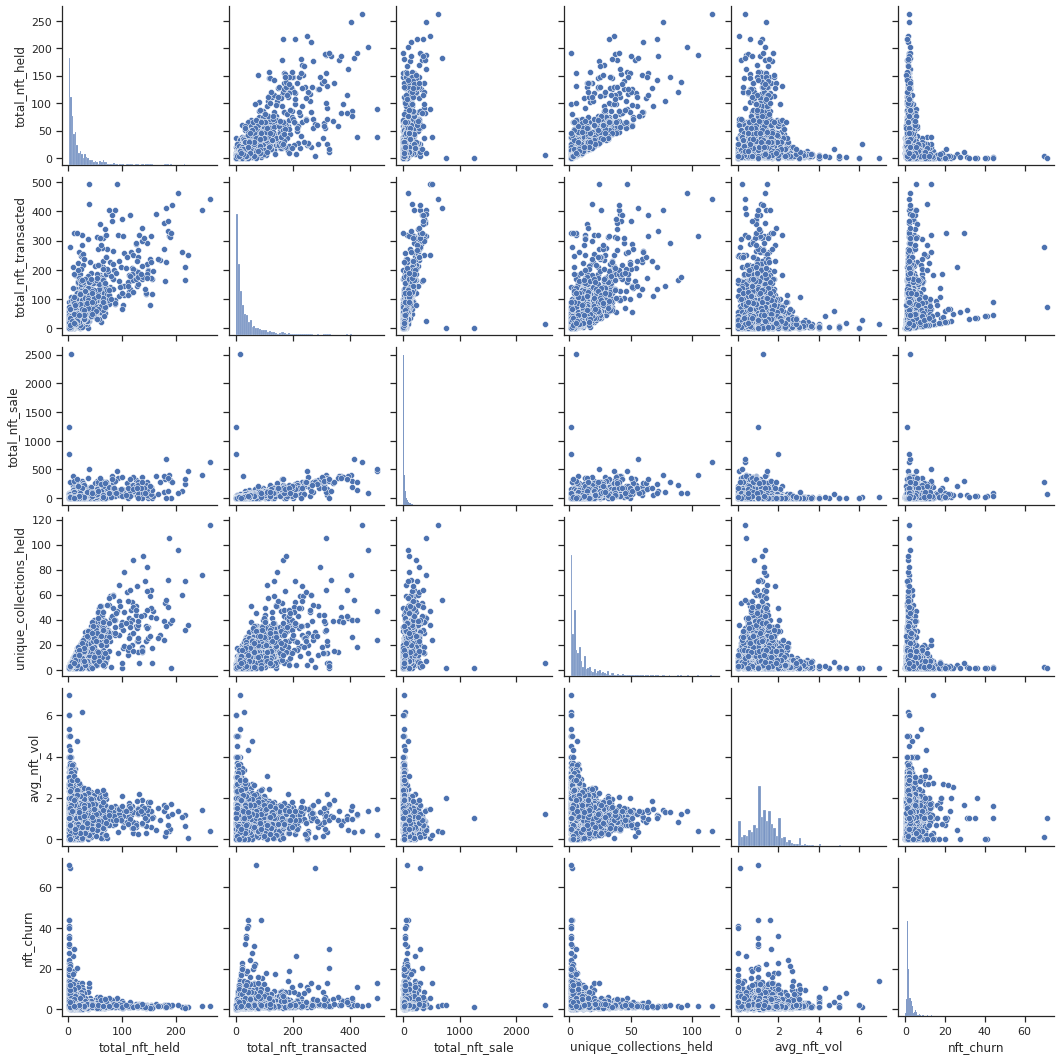

In [14]:
# view a pair-plot / scatter plot matrix of the wallet features
sns.set_theme(style="ticks")
sns.pairplot(feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','nft_churn']])

R2 value: 0.6587006437901763


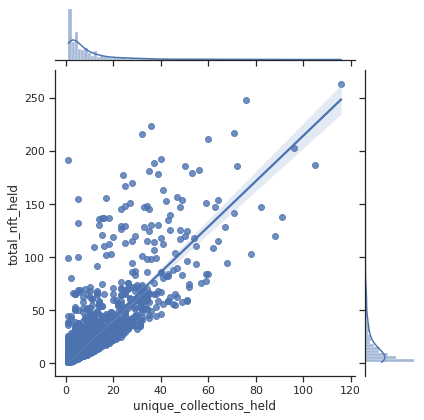

In [23]:
x = feature_df['unique_collections_held']
y = feature_df['total_nft_held']

sns.jointplot(x, y, kind="reg")
print('R2 value: {}'.format(stats.pearsonr(x, y)[0] ** 2))

R2 value: 0.676646826820435


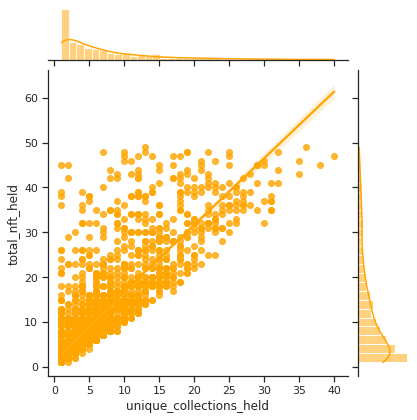

In [28]:
n = 50
x2 = feature_df[feature_df['total_nft_held']< n]['unique_collections_held']
y2 = feature_df[feature_df['total_nft_held']< n]['total_nft_held']

sns.jointplot(x2, y2, kind="reg", color='orange')
print('R2 value: {}'.format(stats.pearsonr(x2, y2)[0] ** 2))

### NFT Wallet Clustering Model (Unsupervised) Build & Evaluation
- k-means model build
- optimal cluster evaluation
- cluster labeling analysis

In [42]:
X = feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','nft_churn']]

score = [] # Calinski-Harabasz / Davies-Bouldin score -- higher is better
distortions = [] # list to hold distorition scores
inertias = [] # list to hold inertia scores
mapping1 = {}
mapping2 = {}

k_min = 2
k_max = 20

k_space = [np.int(x) for x in np.linspace(k_min, k_max, num= k_max-k_min+1)]
for k in k_space:
    # when running KMeans, set init='k-means++', max_iter=100, n_init=1
    cla = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1).fit(X)
    labels = cla.labels_
    # looking for clusterings that have a high Calinski-Harabasz index, but a low Davies-Bouldin score
    ch_score = calinski_harabasz_score(X.to_numpy(), labels)
    db_score = davies_bouldin_score(X.to_numpy(), labels)
    score.append(ch_score / db_score)
    # elbow method
    distortions.append(sum(np.min(cdist(X, cla.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])
    inertias.append(cla.inertia_)
    mapping1[k] = sum(np.min(cdist(X, cla.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = cla.inertia_

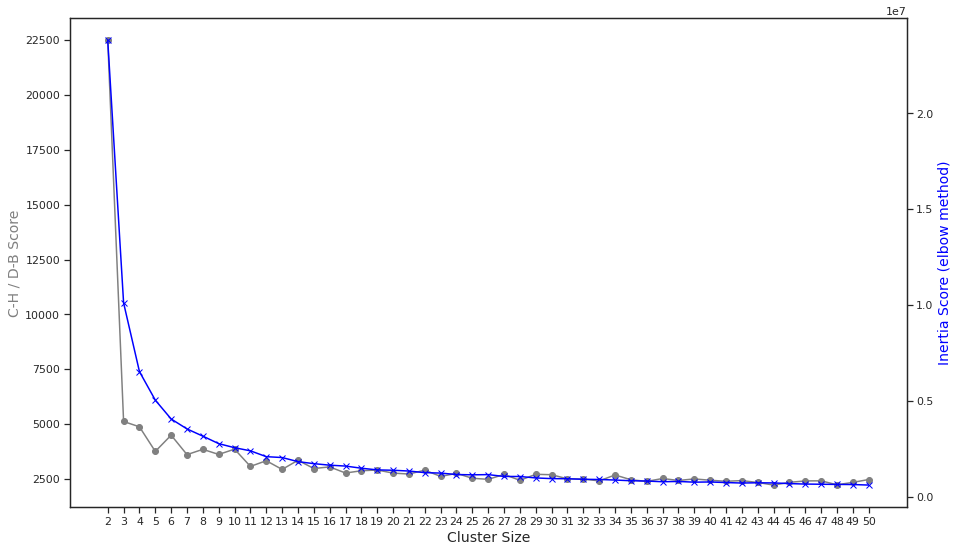

In [39]:
# visualize the classifier performance for different values of K
fig,ax = plt.subplots(figsize=(15,9))
ax.plot(k_space, score, color="grey", marker="o",)
ax.set_xlabel("Cluster Size",fontsize=14)
ax.set_ylabel("C-H / D-B Score",fontsize=14, color='grey')
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(k_space, inertias, color="blue", marker="x")
ax2.set_ylabel("Inertia Score (elbow method)",color="blue",fontsize=14)
plt.xticks(k_space)
plt.show()

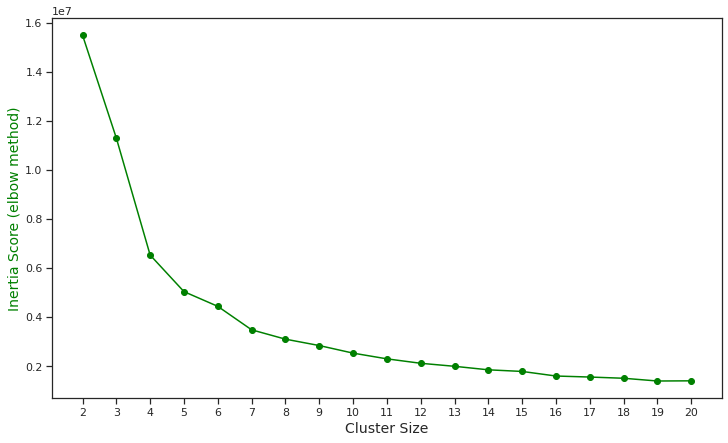

In [44]:
# visualize the classifier performance for different values of K
fig,ax = plt.subplots(figsize=(12,7))
ax.set_xlabel("Cluster Size",fontsize=14)
ax.plot(k_space, inertias, color="green", marker="o")
ax.set_ylabel("Inertia Score (elbow method)",color="green",fontsize=14)
plt.xticks(k_space)
plt.show()

In [51]:
# predict classes for the NFT wallets with k = best k (high C-H index, low D-B score, elbow method for inertia score)
k = 5
cla = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1).fit(X)
feature_df['class_prediction'] = list(cla.predict(X))
feature_df['class_prediction'] = feature_df['class_prediction'].astype(str)

In [52]:
feature_df.groupby('class_prediction').describe()

total_nft_held                                           \
                          count        mean        std  min    25%   50%   
class_prediction                                                           
0                         181.0   74.436464  46.366207  8.0  38.00  62.0   
1                        1652.0    8.162228   7.794939  1.0   3.00   6.0   
2                           2.0    3.500000   3.535534  1.0   2.25   3.5   
3                         446.0   32.107623  19.738677  1.0  17.00  30.0   
4                          57.0  106.929825  68.322988  1.0  59.00  90.0   

                                total_nft_transacted                         \
                     75%    max                count        mean        std   
class_prediction                                                              
0                 112.00  211.0                181.0  167.248619  48.940543   
1                  11.00   49.0               1652.0   13.912228  11.838410   
2                   4.75    6.0                  2.0    7.000000   8.485281   
3                  43.00  113.0                446.0   70.650224  24.083723   
4                 163.00  263.0                 57.0  314.035088  85.142520   

                                                    total_nft_sale  \
                   min    25%    50%     75%    max          count   
class_prediction                                                     
0                 25.0  133.0  161.0  192.00  333.0          181.0   
1                  1.0    4.0   10.0   21.00   63.0         1652.0   
2                  1.0    4.0    7.0   10.00   13.0            2.0   
3                 14.0   52.0   66.0   86.75  156.0          446.0   
4                  2.0  264.0  309.0  368.00  494.0           57.0   

                                                                             \
                         mean         std     min      25%     50%      75%   
class_prediction                                                              
0                  137.226519   56.327698     0.0   104.00   137.0   172.00   
1                    9.461259   10.097121     0.0     1.00     6.0    15.00   
2                 1876.500000  890.247438  1247.0  1561.75  1876.5  2191.25   
3                   57.957399   26.192897     0.0    40.00    54.0    76.00   
4                  324.035088  116.092015    82.0   263.00   298.0   359.00   

                         unique_collections_held                             \
                     max                   count       mean        std  min   
class_prediction                                                              
0                  394.0                   181.0  27.613260  17.236739  1.0   
1                   54.0                  1652.0   4.707627   4.050991  1.0   
2                 2506.0                     2.0   3.000000   2.828427  1.0   
3                  147.0                   446.0  15.219731   9.782634  1.0   
4                  762.0                    57.0  37.508772  25.037203  1.0   

                                          max_collection_count             \
                   25%   50%   75%    max                count       mean   
class_prediction                                                            
0                 14.0  25.0  36.0   91.0                181.0  17.812155   
1                  2.0   3.0   6.0   25.0               1652.0   3.257869   
2                  2.0   3.0   4.0    5.0                  2.0   1.500000   
3                  8.0  13.0  21.0   68.0                446.0   8.419283   
4                 20.0  36.0  50.0  116.0                 57.0  19.403509   

                                                            \
                        std  min   25%   50%    75%    max   
class_prediction                                             
0                 22.999712  2.0  6.00  10.0  20.00  191.0   
1                  3.893817  1.0  1.00   2.0   3.00   44.0   
2                  0.

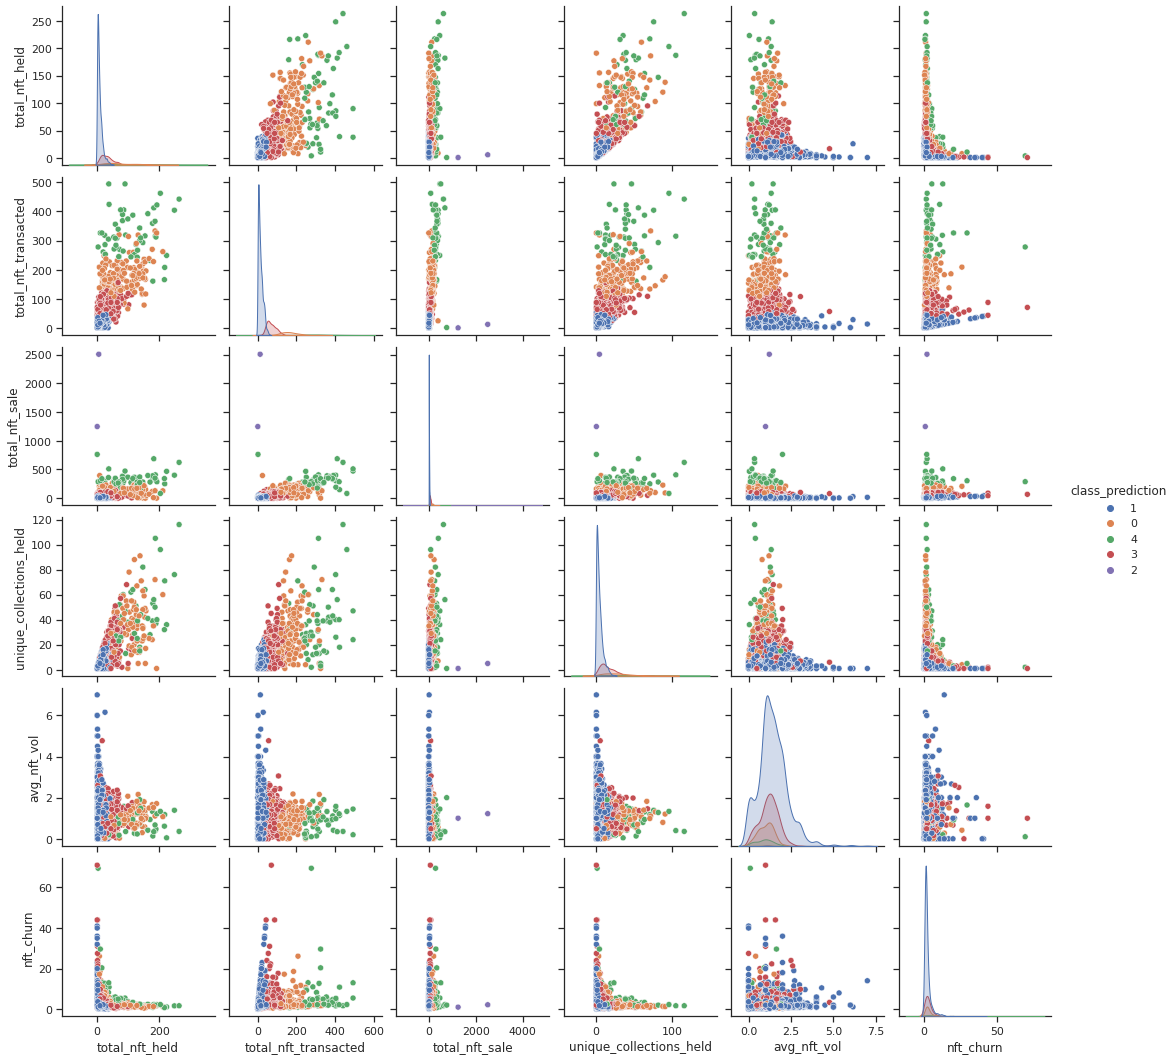

In [53]:
#sns.set_theme(style="ticks")
sns.pairplot(feature_df[['total_nft_held','total_nft_transacted','total_nft_sale','unique_collections_held','avg_nft_vol','class_prediction','nft_churn']], hue='class_prediction')

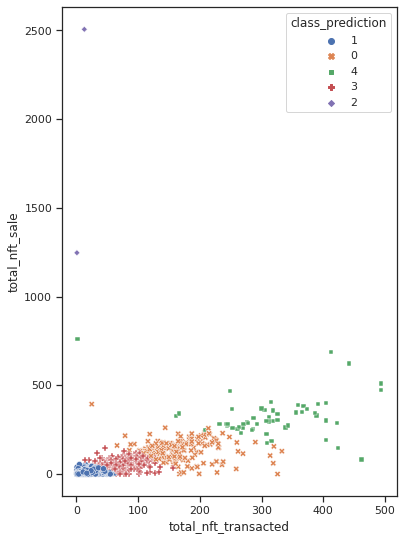

In [55]:
x = 'total_nft_transacted'
y = 'total_nft_sale'
fig,ax = plt.subplots(figsize=(6,9))
sns.scatterplot(data=feature_df, x=x, y=y, hue="class_prediction", style="class_prediction")


### Other Code (placeholder)
- BUILD DATABASE OF OS IMAGES TO TRAIN A CNN

In [ ]:
# # first get the image URL from OS
# # helper func to get the nft asset image url file
# def get_nft_image_url(token_id,asset_contract_address):
#   url = "https://api.opensea.io/api/v1/assets?token_ids={}&order_by=pk&order_direction=desc&asset_contract_address={}&limit=20&include_orders=true".format(token_id,asset_contract_address)
#   headers = {"Accept": "application/json","X-API-KEY": "d4222f42fc6c4a79a3883926a81c4a95"}
#   response = requests.request("GET", url, headers=headers)
#   nft_image_url = dict(response.json())['assets'][0]['image_url']
#   return nft_image_url

# pd.set_option('display.max_rows',250)
# df.iloc[500000].asset_asset_contract_address

# token_id = '93751882162263358060651260285234307757752326041288358141288876844389834424321'
# contract_address = '0x495f947276749ce646f68ac8c248420045cb7b5e'

# get_nft_image_url(token_id,contract_address)


# BUILD DATABASE OF OS NFT IMAGES
# BELOW GENERATES LINKS TO OS IMAGE FOR EACH RECORD IN DATABASE

# # set directory to output folder
# os.chdir('/content/nft_images')
# # get the unique set of nft asset ids and contract addresses
# nft_lookup = list(df[['asset_token_id','asset_asset_contract_address']].to_records(index=False))

# tokens = []
# for nft_record in nft_lookup[0:1000]:  
#   token_id = str(nft_record[0])
#   contract_address = str(nft_record[1])

#   # need to build in a way to assess whether we already have an nft image based on CSV log!
#   # if we do not already have token then append existing log with new images
#   # existing_token_images = pd.read_csv()
#   try:
#     url = get_nft_image_url(token_id,contract_address)
#     urllib.request.urlretrieve("{}".format(url), "{}_{}.jpg".format(token_id,contract_address))
#     tokens.append((token_id,contract_address))
#   except:
#     pass
  
# payload = pd.DataFrame(tokens, columns=['token_id', 'token_contract_address'])
# payload.to_csv('nft_image_payload_20220304.csv',index=False)
# print('stopped at record {}'.format(nft_record))

# zip the images folder for download
# !zip -r /content/nft_images.zip /content/nft_images

# from google.colab import files
# files.download("/content/nft_images.zip")